# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os

import warnings
warnings.filterwarnings('ignore')

import cv2
import imageio


import matplotlib.pyplot as plt
%matplotlib inline

import datetime

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)

import tensorflow as tf
tf.random.set_seed(30)

In [3]:
from keras import backend as K

Using TensorFlow backend.


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
#train_doc = np.random.permutation(open('/Users/snehalgunde/Desktop/Upgrad/Gesture Recognisation/Project_data/train.csv').readlines())
#val_doc = np.random.permutation(open('/Users/snehalgunde/Desktop/Upgrad/Gesture Recognisation/Project_data/val.csv').readlines())
batch_size = 64 #experiment with the batch size
train_doc = np.random.permutation(open('./Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('./Project_data/val.csv').readlines())


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
sample_image = os.listdir('./Project_data/train'+'/'+ np.random.permutation(train_doc)[0 + (0)].split(';')[0])

In [6]:
print(sample_image)

['WIN_20180926_17_24_58_Pro_00063.png', 'WIN_20180926_17_24_58_Pro_00061.png', 'WIN_20180926_17_24_58_Pro_00049.png', 'WIN_20180926_17_24_58_Pro_00065.png', 'WIN_20180926_17_24_58_Pro_00059.png', 'WIN_20180926_17_24_58_Pro_00015.png', 'WIN_20180926_17_24_58_Pro_00029.png', 'WIN_20180926_17_24_58_Pro_00017.png', 'WIN_20180926_17_24_58_Pro_00007.png', 'WIN_20180926_17_24_58_Pro_00013.png', 'WIN_20180926_17_24_58_Pro_00011.png', 'WIN_20180926_17_24_58_Pro_00039.png', 'WIN_20180926_17_24_58_Pro_00009.png', 'WIN_20180926_17_24_58_Pro_00021.png', 'WIN_20180926_17_24_58_Pro_00035.png', 'WIN_20180926_17_24_58_Pro_00023.png', 'WIN_20180926_17_24_58_Pro_00037.png', 'WIN_20180926_17_24_58_Pro_00033.png', 'WIN_20180926_17_24_58_Pro_00027.png', 'WIN_20180926_17_24_58_Pro_00019.png', 'WIN_20180926_17_24_58_Pro_00031.png', 'WIN_20180926_17_24_58_Pro_00025.png', 'WIN_20180926_17_24_58_Pro_00057.png', 'WIN_20180926_17_24_58_Pro_00043.png', 'WIN_20180926_17_24_58_Pro_00055.png', 'WIN_20180926_17_24_58_P

In [7]:
sample_im_path = './Project_data/train'+'/'+ train_doc[0].split(';')[0]
sample = cv2.imread(sample_im_path+'/'+os.listdir(sample_im_path)[0])

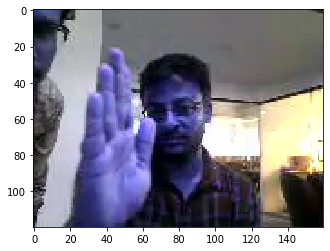

In [8]:
plt.imshow(sample)

In [9]:
sample.shape

(120, 160, 3)

In [10]:
sample = cv2.resize(sample,(120,120))

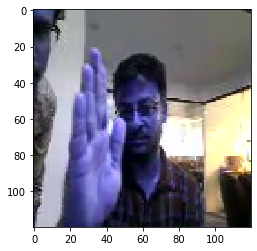

In [11]:
plt.imshow(sample)

In [12]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.arange(0,30,3) #create a list of image numbers you want to use for a particular video
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(folder_list)//batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = cv2.resize(image,(120,120))
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        rem_image = len(folder_list)%batch_size
        batch += 1
        if(rem_image!=0):
            batch_data = np.zeros((rem_image,len(img_idx),120,120,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((rem_image,5)) # batch_labels is the one hot representation of the output
            for folder in range(rem_image): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                   
                    image = cv2.resize(image,(120,120))
                    image = image - np.percentile(image,5)/ np.percentile(image,95) - np.percentile(image,5)
                    batch_data[folder,idx,:,:,0] = image[:,:,0]
                    batch_data[folder,idx,:,:,1] = image[:,:,1]
                    batch_data[folder,idx,:,:,2] = image[:,:,2]
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = '/Users/snehalgunde/Desktop/Upgrad/Gesture Recognisation/Project_data/train'
val_path = '/Users/snehalgunde/Desktop/Upgrad/Gesture Recognisation/Project_data/val'
#train_path = './Project_data/train'
#val_path = './Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


## Model - 1
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout,Input
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN


#write your model here 

from keras.regularizers import l2

model1 = Sequential()

model1.add(TimeDistributed(Conv2D(16, (2, 2), padding='same'),
                 input_shape=(10,120,120,3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(TimeDistributed(Conv2D(16, (2, 2))))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model1.add(Dropout(0.2))

model1.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(TimeDistributed(Conv2D(32, (2, 2), padding='same')))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model1.add(Dropout(0.2))

model1.add(TimeDistributed(Flatten()))
model1.add(LSTM(256, return_sequences=False, dropout=0.5))
model1.add(Dense(64,kernel_regularizer=l2(0.01)))
model1.add(Activation('relu'))
model1.add(Dropout(0.25))
model1.add(Dense(5))
model1.add(Activation('softmax'))
 

2022-02-28 09:36:24.904384: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-28 09:36:24.905662: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [15]:

model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 10, 120, 120, 16)  208       
_________________________________________________________________
activation_1 (Activation)    (None, 10, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 10, 119, 119, 16)  1040      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 119, 119, 16)  0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 10, 119, 119, 16)  64        
_________________________________________________________________
time_distributed_3 (TimeDist (None, 10, 59, 59, 16)   

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [16]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [17]:
model_name = 'model_' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR= ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)  # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [18]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [19]:
print(steps_per_epoch)
print(validation_steps)


11
2


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

## Experiment No.1 

- Model1 = 2D+RNN with LSTM
- batch size = 64
- Number of epoch=10
- optimizer = Adam

In [23]:


model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None,
                     workers=1, initial_epoch=0)

Epoch 1/10
11/11 [==============================] - 1108s 101s/step - loss: 1.5438 - categorical_accuracy: 0.6923 - val_loss: 2.8023 - val_categorical_accuracy: 0.2800

Epoch 00001: saving model to model__2022-02-2608_45_39.247895/model-00001-1.54594-0.69231-2.80226-0.28000.h5
Epoch 2/10
11/11 [==============================] - 1166s 106s/step - loss: 1.3363 - categorical_accuracy: 0.7587 - val_loss: 2.8978 - val_categorical_accuracy: 0.1900

Epoch 00002: saving model to model__2022-02-2608_45_39.247895/model-00002-1.33442-0.75867-2.89783-0.19000.h5
Epoch 3/10
11/11 [==============================] - 1042s 95s/step - loss: 1.0955 - categorical_accuracy: 0.8582 - val_loss: 3.1468 - val_categorical_accuracy: 0.2100

Epoch 00003: saving model to model__2022-02-2608_45_39.247895/model-00003-1.09505-0.85822-3.14679-0.21000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/10
11/11 [==============================] - 978s 89s/step - loss: 0.9628 - cat

## Experiment No.2

- Model1 = 2D+RNN with LSTM
- batch size = 64
- Number of epoch= 50
- optimizer = Adam

In [ ]:
#changing epochs to 50



model1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None,
                     workers=1, initial_epoch=0)

Epoch 1/50
Source path =  Source path = /Users/snehalgunde/Desktop/Upgrad/Gesture Recognisation/Project_data/val ; batch size = 64 /Users/snehalgunde/Desktop/Upgrad/Gesture Recognisation/Project_data/train ; batch size = 64

11/11 [==============================] - 1113s 101s/step - loss: 2.5196 - categorical_accuracy: 0.3047 - val_loss: 2.9819 - val_categorical_accuracy: 0.2000

Epoch 00001: saving model to model__2022-02-2809_36_24.875803/model-00001-2.53385-0.30468-2.98194-0.20000.h5
Epoch 2/50
11/11 [==============================] - 1306s 119s/step - loss: 2.0572 - categorical_accuracy: 0.5068 - val_loss: 2.8906 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model__2022-02-2809_36_24.875803/model-00002-2.06269-0.50679-2.89056-0.23000.h5
Epoch 3/50
11/11 [==============================] - 7542s 686s/step - loss: 1.7800 - categorical_accuracy: 0.6048 - val_loss: 3.2116 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model__2022-02-2809_36_24.875803

## Model - 2 

- CON3D + Activation fun('Relu') + MaxPooling3D + BatchNormalization + Dropout + Falttened
- kernel size = (3,3,3)

In [24]:
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5

model2 = Sequential()
model2.add(Conv3D(nb_featuremap[0], 
                 kernel_size=(5,5,5),
                 input_shape=(10, 120, 120, 3),
                 padding='same', name="conv1"))
model2.add(Activation('relu'))
model2.add(Conv3D(nb_featuremap[1], 
                 kernel_size=(3,3,3),
                 padding='same',name="conv2"))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))
model2.add(Conv3D(nb_featuremap[2], 
                 kernel_size=(1,3,3), 
                 padding='same',name="conv3"))
model2.add(Activation('relu'))
model2.add(MaxPooling3D(pool_size=(2,2,2)))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))
model2.add(MaxPooling3D(pool_size=(2,2,2)))
model2.add(Flatten())
model2.add(Dense(nb_dense[0], activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(nb_dense[1], activation='relu'))
#softmax layer
model2.add(Dense(nb_dense[2], activation='softmax'))


In [25]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 10, 120, 120, 8)   3008      
_________________________________________________________________
activation_7 (Activation)    (None, 10, 120, 120, 8)   0         
_________________________________________________________________
conv2 (Conv3D)               (None, 10, 120, 120, 16)  3472      
_________________________________________________________________
activation_8 (Activation)    (None, 10, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 60, 60, 16)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 5, 60, 60, 32)     4640      
_________________________________________________________________
activation_9 (Activation)    (None, 5, 60, 60, 32)    

## Experiment No - 3

- Model1 = Conv3D 
- kernel size - (5,5,5)
- batch size = 64
- Number of epoch=10
- optimizer = Adam

In [26]:
model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                      callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, 
                      workers=1, initial_epoch=0,use_multiprocessing=True)

#model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
#                    callbacks=callbacks_list, validation_data=val_generator, validation_steps=validation_steps, class_weight=None,
#                     workers=1, initial_epoch=0)

Epoch 1/10
11/11 [==============================] - 373s 34s/step - loss: 4.1661 - categorical_accuracy: 0.2489 - val_loss: 25.1646 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model__2022-02-2608_45_39.247895/model-00001-4.05145-0.24887-25.16465-0.24000.h5
Epoch 2/10
11/11 [==============================] - 358s 33s/step - loss: 1.6799 - categorical_accuracy: 0.3741 - val_loss: 7.5693 - val_categorical_accuracy: 0.2900

Epoch 00002: saving model to model__2022-02-2608_45_39.247895/model-00002-1.67514-0.37406-7.56933-0.29000.h5
Epoch 3/10
11/11 [==============================] - 360s 33s/step - loss: 1.2019 - categorical_accuracy: 0.5068 - val_loss: 9.0179 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model__2022-02-2608_45_39.247895/model-00003-1.18283-0.50679-9.01788-0.23000.h5
Epoch 4/10
11/11 [==============================] - 366s 33s/step - loss: 0.9731 - categorical_accuracy: 0.6425 - val_loss: 8.8333 - val_categorical_accuracy: 0.1800

Epo

## Experiment No - 4

- Model1 = Conv3D 
- kernel size -  (5,5,5)
- batch size = 64
- Number of epoch=10
- optimizer = sgd

In [27]:
model2.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 10, 120, 120, 8)   3008      
_________________________________________________________________
activation_7 (Activation)    (None, 10, 120, 120, 8)   0         
_________________________________________________________________
conv2 (Conv3D)               (None, 10, 120, 120, 16)  3472      
_________________________________________________________________
activation_8 (Activation)    (None, 10, 120, 120, 16)  0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 60, 60, 16)     0         
_________________________________________________________________
conv3 (Conv3D)               (None, 5, 60, 60, 32)     4640      
_________________________________________________________________
activation_9 (Activation)    (None, 5, 60, 60, 32)    

In [28]:
model2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                      callbacks=callbacks_list, validation_data=val_generator,validation_steps=validation_steps, class_weight=None, 
                      workers=1, initial_epoch=0,use_multiprocessing=True)



Epoch 1/10
11/11 [==============================] - 366s 33s/step - loss: 0.3251 - categorical_accuracy: 0.8944 - val_loss: 1.3239 - val_categorical_accuracy: 0.6000

Epoch 00001: saving model to model__2022-02-2608_45_39.247895/model-00001-0.33521-0.89442-1.32394-0.60000.h5
Epoch 2/10
11/11 [==============================] - 366s 33s/step - loss: 0.4452 - categorical_accuracy: 0.8401 - val_loss: 3.3869 - val_categorical_accuracy: 0.2800

Epoch 00002: saving model to model__2022-02-2608_45_39.247895/model-00002-0.44561-0.84012-3.38694-0.28000.h5
Epoch 3/10
11/11 [==============================] - 373s 34s/step - loss: 0.3365 - categorical_accuracy: 0.8854 - val_loss: 0.9962 - val_categorical_accuracy: 0.6000

Epoch 00003: saving model to model__2022-02-2608_45_39.247895/model-00003-0.33866-0.88537-0.99625-0.60000.h5
Epoch 4/10
11/11 [==============================] - 387s 35s/step - loss: 0.3336 - categorical_accuracy: 0.8884 - val_loss: 1.0475 - val_categorical_accuracy: 0.6200

Epoch

## Model - 3

- CON3D + Activation fun('Relu') + MaxPooling3D + BatchNormalization + Dropout + Falttened
- kernel size = (3,3,3)

## Experiment No - 5

- Model1 = Conv3D 
- kernel size - (3,3,3)
- batch size = 64
- Number of epoch=20
- optimizer = adam

In [29]:
# Define model b
model4 = Sequential()
model4.add(Conv3D(32, kernel_size=(3, 3, 3), input_shape=(10, 120, 120, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv3D(32, kernel_size=(3, 3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model4.add(BatchNormalization())

model4.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv3D(64, kernel_size=(3, 3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model4.add(BatchNormalization())

model4.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(Conv3D(128, kernel_size=(3, 3, 3), padding='same'))
model4.add(Activation('relu'))
model4.add(MaxPooling3D(pool_size=(3, 3, 3), padding='same'))
model4.add(BatchNormalization())

model4.add(Flatten())
model4.add(Dense(512, activation='relu'))
model4.add(Dropout(0.5))
model4.add(Dense(64, activation='relu'))
model4.add(Dense(5, activation='softmax'))

model4.compile(optimizer=optimizers.Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model4.summary()
 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 10, 120, 120, 32)  2624      
_________________________________________________________________
activation_10 (Activation)   (None, 10, 120, 120, 32)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 120, 120, 32)  27680     
_________________________________________________________________
activation_11 (Activation)   (None, 10, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 4, 40, 40, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 40, 40, 32)     128       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 4, 40, 40, 64)    

In [30]:
model4.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=20, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
11/11 [==============================] - 1003s 91s/step - loss: 1.7516 - categorical_accuracy: 0.3725 - val_loss: 55.7012 - val_categorical_accuracy: 0.2300

Epoch 00001: saving model to model__2022-02-2608_45_39.247895/model-00001-1.74785-0.37255-55.70118-0.23000.h5
Epoch 2/20
11/11 [==============================] - 1025s 93s/step - loss: 1.2178 - categorical_accuracy: 0.4977 - val_loss: 58.9546 - val_categorical_accuracy: 0.2300

Epoch 00002: saving model to model__2022-02-2608_45_39.247895/model-00002-1.18482-0.49774-58.95459-0.23000.h5
Epoch 3/20
11/11 [==============================] - 1202s 109s/step - loss: 1.0004 - categorical_accuracy: 0.6109 - val_loss: 40.7700 - val_categorical_accuracy: 0.2300

Epoch 00003: saving model to model__2022-02-2608_45_39.247895/model-00003-1.00877-0.61086-40.77000-0.23000.h5
Epoch 4/20
11/11 [==============================] - 1347s 122s/step - loss: 0.8657 - categorical_accuracy: 0.6772 - val_loss: 28.1724 - val_categorical_accuracy: 

## Experiment No - 6

- Model1 = Conv3D 
- kernel size - (3,3,3)
- batch size = 64
- Number of epoch=20
- optimizer = 'sgd'

In [31]:

model4.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 10, 120, 120, 32)  2624      
_________________________________________________________________
activation_10 (Activation)   (None, 10, 120, 120, 32)  0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 10, 120, 120, 32)  27680     
_________________________________________________________________
activation_11 (Activation)   (None, 10, 120, 120, 32)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 4, 40, 40, 32)     0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 4, 40, 40, 32)     128       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 4, 40, 40, 64)    